In [144]:
from datetime import datetime, timedelta
import os
import time
import requests
import random
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
import doctor
import math
from IPython.display import clear_output
import main
import seaborn as sea
import matplotlib.patches as patches
import matplotlib as mpl
import ryan_tools as rt
#import keras as kr
import glob

### Open

In [145]:
def plot_candles(candles, signal, fig, ax):
    def add_rectangle(i, open_, close,low, high, ax, sig):
        x = i - .5
        y = min(open_, close)
        height = abs(open_ - close)
        if sig == 'buy':
            color = 'green'
            hatch = 'x'
        if sig == 'sell':
            color = 'red'
            hatch = ''
            
        if sig == 'hold':
            color = 'orange'
            hatch = ''
        ax.add_patch(patches.Rectangle((x, y), .9, height,
                                       fill = open_ <= close, facecolor = color,
                                       edgecolor = color, hatch = hatch ))
        top = max(open_,close)
        bottom = min(open_,close)

        if low < bottom:
            ax.add_line(mpl.lines.Line2D([i,i], [low, bottom], color = color) )

            
        if high > top:
            ax.add_line(mpl.lines.Line2D([i,i], [high, top], color = color) )

        
    for i, index in enumerate(candles.index):
        sig = signal.loc[index]
        row = candles.loc[index]
        add_rectangle(i, row['open'], row['close'],row['low'], row['high'],  ax, sig)
    ax.set_xlim(0, len(candles))
    ax.set_ylim(candles['close'].min() *.998, candles['close'].max() * 1.002)
    return ax

In [4]:
def chartio(gran = 60, cans = False, count = False):
    if type(cans) == type(False):
        cans = aba.get_candles(granularity= gran)
    if count == False:
        count = len(cans)
    mask = cans['open']< cans['close']
    signal = pd.Series(index = cans.index )
    signal.loc[mask] = 'buy'
    signal.loc[~mask] = 'sell'

    
    
    fig, (ax, sig_ax) = plt.subplots(nrows = 2, sharex= False)
    fig.set_size_inches(7, 9)
    plot_candles(cans[-count:], signal[-count:], fig, ax)
    ax.set_xticklabels(cans.index)
    ax2 = ax.twinx()
    cans.iloc[-count:]['volume'].plot(kind = 'bar', ax = ax2, alpha = 0.3)
    

    rsi = aba.get_rsi(cans['close'])
    macd = aba.get_macd(cans)
    rsi.plot(ax = sig_ax, alpha = 0.1)
    ax4 = sig_ax.twinx()
    macd[['macd', 'macd_signal']].plot(ax = ax4)
    plt.show()
    

In [135]:
def get_time_range(start,aba, end, gran = 60):
    next_val = start + timedelta(seconds = 200 * gran)
    result = pd.DataFrame()
    bar = rt.progress_bar((end - start).total_seconds()/(gran* 200))
    while next_val < end:
        bar.progress()
        temp = aba.get_candles(start, next_val, gran)
        result = result.append(temp)
        start = next_val
        next_val = next_val + timedelta(seconds = 200 * gran)
    return result

In [136]:
class Test_candles():
    abas = None
    data =None
    def __init__(self, days = 30):
            
        abas = {}
        abas['LTC'] = main.Abathor('LTC-USD')
        abas['ETH'] = main.Abathor('ETH-USD')
        abas['BTC'] = main.Abathor('BTC-USD')
        abas['BCH'] = main.Abathor('BCH-USD')
        self.abas = abas
        
        data = {}
        start = datetime.today() - timedelta(days= days)
    
            
        for pair in abas.keys():
            aba = abas[pair]
            data[pair] = {}
            for gran in (60, 60 * 5, 60 * 15, 60 * 60):
                data[pair][gran] = get_time_range(start, aba, datetime.today(), gran = gran)

        self.data = data
    

t = Test_candles()

0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o>                                             | 76.86 % 
Done: 2 Remaining: 1.6021823514694447, Remaining Time: 2s


In [140]:
with open('test_candles', 'wb') as f:
    pickle.dump(t, f)

In [141]:
with open('test_candles', 'rb') as f:
    n_t = pickle.load(f)

In [83]:

class Testy():
    cash = None
    coin = None
    position = None
    trades = None
    cost = None
    trade_history = None
    stoploss = None
    buy_price = None
    target_percent = None
    
    def __init__(self, cash = 100, coin = 0, position = 'out', stoploss = False, target_percent = False):
        assert(position in ('in', 'out'))
        self.cash = cash
        self.coin = coin
        self.position = position
        self.trades = 0
        self.trade_history = []
        self.cost = 0
        self.stoploss = stoploss
        self.target_percent = target_percent
        
    def sell(self, p):
        if self.position == 'out':
            return 
        self.cash = self.coin * p
        self.cost = self.cost + (0.003 * self.cash)
        self.coin = 0
        self.position = 'out'
        self.trades = self.trades + 1
        spot = len(self.trade_history) - 1
        self.trade_history[spot] = (self.cash - self.trade_history[spot])/self.trade_history[spot]
        
        return 
    
    def buy(self, p):
        if self.position == 'in':
            return
        self.trade_history.append(self.cash)
        self.coin = self.cash/p
        self.cost = self.cost + (0.003 * self.cash)
        self.cash = 0
        self.position = 'in'
        self.trades = self.trades + 1
        self.buy_price = p
        return
        

    def test_signal(self, prices, signal):
        for i in range(len(signal)):
            p = prices.iloc[i]
            s = signal.iloc[i]
            
            if (self.stoploss != False) and (self.position) == 'in':
                if p <= ((1 - self.stoploss) * self.buy_price):                   
                    s = 'sell'
            if (self.target_percent != False) and (self.position) == 'in':
                if p >= ((1 + self.target_percent) * self.buy_price):
                    s = 'sell'
                    
            if s == 'sell':
                self.sell(p)
                
            if s == 'buy':
                self.buy(p)
            if s == 'hold':
                s = 'hold'
                
        self.sell(p)
        return self.cash, self.coin, self.trades
    
    def __str__(self):
        text = 'Trades {:,.0f} | Cash $ {:.2f} | Cost $ {:,.2f}'.format(self.trades, self.cash, self.cost )
        return text
    
    def study(self):
        print(self)
        print('Value Distribution')
        th = np.array(self.trade_history)
        sea.distplot(th, kde = False)
        plt.show()
        print('Average Change: {:.4f} %'.format(np.mean(th) * 100))
        print('Max Drawdown: {:.4f} %'.format(min(th)* 100))
    
    def get_sharpe(self):
        hist = pd.Series(self.trade_history)
        hist = hist[hist <0] 
        returns = (self.cash - 100)/100
        return returns/hist.apply(abs).mean()
        
        
        

Trades 1,660 | Cash $ 43.30 | Cost $ 310.92
Value Distribution


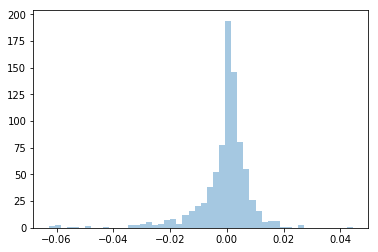

Average Change: -0.0956 %
Max Drawdown: -6.2825 %


In [108]:
rsi = aba.get_rsi(cans, 15)
signal = pd.Series(index = cans.index)
signal.loc[signal.index] = 'hold'
signal.loc[rsi < 30] = 'buy'
signal.loc[rsi > 70] = 'sell'

test = Testy()
test.test_signal(cans['close'], signal)
test.study()

Trades 5,160 | Cash $ 42.50 | Cost $ 1,042.86
Value Distribution


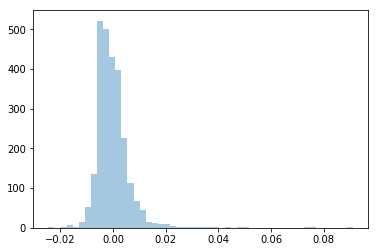

Average Change: -0.0311 %
Max Drawdown: -2.4622 %


In [98]:
def signal_generator(cans, aba, bull_rsi, bear_rsi):
    macd = aba.get_macd(cans, 800, 40)
    bursi = aba.get_rsi(cans, 10)
    bersi = aba.get_rsi(cans, 15)
    
    market = pd.Series(index = cans.index)
    market.loc[market.index] = 'sideways'
    market.loc[macd['macd'] > macd['macd_signal']] = 'bull'
    market.loc[macd['macd'] < macd['macd_signal']] = 'bear'
 
    signal = pd.Series(index = cans.index)
    signal.loc[signal.index] = 'hold'
    
    #In a bull market use bull rsi
    signal.loc[(market == 'bull') & (bursi > bull_rsi['high'])] = 'sell'
    signal.loc[(market == 'bull') & (bursi < bull_rsi['low'])] = 'buy'
    
    #In a bear market use bear rsi
    signal.loc[(market == 'bear') & (bersi > bear_rsi['high'])] = 'sell'
    signal.loc[(market == 'bear') & (bersi < bear_rsi['low'])] = 'buy'
    
    return signal

bull_rsi = {}
bull_rsi['high'] = 80
bull_rsi['low'] = 50

bear_rsi = {}
bear_rsi['high'] = 50
bear_rsi['low'] = 25
 
x = cans.copy()
signal = signal_generator(x, aba, bull_rsi, bear_rsi)

testy = Testy(stoploss= .003)
testy.test_signal(x['close'], signal)
testy.study()

Trades 2,270 | Cash $ 53.93 | Cost $ 516.93
Value Distribution


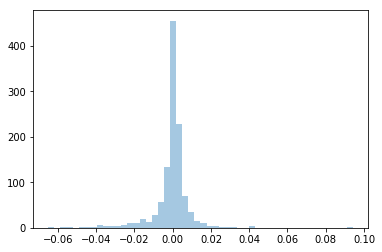

Average Change: -0.0497 %
Max Drawdown: -6.5018 %


In [16]:
def plot_signal(ax, prices, signal):
    lim = ax.get_ylim()
    last_sig = signal.iloc[0]
    batch_x = []
    batch_y = []
    colors = {'buy':'green',
             'sell':'red',
             'hold':'blue'}
    
    for i, s in enumerate(signal):
        color = colors[last_sig]
        p = prices.iloc[i]
        if s == last_sig:
            batch_x.append(prices.index[i])
            batch_y.append(p)
        if s != last_sig:
            batch_x.append(prices.index[i])
            batch_y.append(p)
            ax.plot(batch_x, batch_y, color = color)
            batch_x = [prices.index[i]]
            batch_y = [p]
            if colors[s] != 'blue':
                ax.vlines(prices.index[i], lim[0], lim[1], color = colors[s])
        last_sig = s
    ax.plot(batch_x, batch_y, color = color)
            

In [126]:
def test_time_period(x, time, sd):
    data = volume_info(bolinger_signal(x,time, numsd=sd))
    data['width'] = data['upper'] - data['lower']
    data = data.dropna()
    data['signal'] = 'hold'
    data.loc[data['close'] < data['avg'], 'signal'] = 'sell'
    data.loc[data['close'] > data['upper'], 'signal'] = 'buy'
    
    test = Testy()
    test.test_signal(data['close'], data['signal'])
    return test
'''
result = pd.DataFrame(index = list(range(2,1000)))
for index in result.index:
    test = test_time_period(x, index, 1)
    

    result.loc[index, 'cash'] = test.cash
    result.loc[index, 'trades'] = test.trades
    t = result[~result['cash'].isnull()]
    fig, ax = plt.subplots()
    ax.plot(t['cash'])
    ax.set_ylabel('Money')
    ax.set_xlabel('Time Period')
    
    ax2 = ax.twinx()
    ax2.plot(t['trades'], color = 'green')
    ax2.set_ylabel('Trade Count')
    plt.show()
    rt.clear_output(True)
    
    '''

"\nresult = pd.DataFrame(index = list(range(2,1000)))\nfor index in result.index:\n    test = test_time_period(x, index, 1)\n    \n\n    result.loc[index, 'cash'] = test.cash\n    result.loc[index, 'trades'] = test.trades\n    t = result[~result['cash'].isnull()]\n    fig, ax = plt.subplots()\n    ax.plot(t['cash'])\n    ax.set_ylabel('Money')\n    ax.set_xlabel('Time Period')\n    \n    ax2 = ax.twinx()\n    ax2.plot(t['trades'], color = 'green')\n    ax2.set_ylabel('Trade Count')\n    plt.show()\n    rt.clear_output(True)\n    \n    "

## Buy and Hold

In [1481]:
data.keys()

dict_keys(['LTC', 'ETH', 'BTC', 'BCH'])

In [1483]:
def do_buy_and_hold(x):
    temp = x.copy()
    temp['signal'] = 'buy'

    test = Testy(stoploss= False)
    test.test_signal(temp['close'], temp['signal'])
    print(test)
    
    
do_buy_and_hold(data['ETH'])

Trades 2 | Cash $ 60.39 | Cost $ 0.48


In [1521]:
signal = data['ETH']['close'] > 0
signal.loc[signal.values] = 'buy'
test = Testy()

In [1522]:
test.test_signal(data['ETH']['close'], signal)

(60.392188207710547, 0, 2)

In [1525]:
test.cash

60.392188207710547

In [1527]:
def try_things(x, signal_time, deviation, max_loss, target_percent, flip = False):
    data = volume_info(bolinger_signal(x,signal_time , deviation))
    data = data.dropna()
    data['signal'] = 'hold'
    bmask = data['close'].rolling(3).mean().bfill() < data['lower']
    smask = data['close'].rolling(3).mean().bfill() > data['upper'] 
    if flip:
        bmask,smask = smask,bmask
    
    data.loc[bmask, 'signal'] = 'buy'
    data.loc[smask, 'signal'] = 'sell'
        
    test = Testy(stoploss= max_loss, target_percent= target_percent)
    test.test_signal(data['close'], data['signal'])
    
    def mmean(listo):
        try:
            ans = round(np.mean(listo), 4)
        except IndexError:
            ans = -100
        return ans
    
    trades = np.mean(test.trade_history)
    
    if flip:
        test.cash = test.cash - test.cost
        
    result = {'signal_time':signal_time,
             'deviation':deviation,
             'max_loss':max_loss,
             'target_percent':target_percent,
             'average_gain':mmean(test.trade_history),
             'flip':flip,
             'sharpe':test.get_sharpe()
             }

    return result, test

def get_score(cashes):

            
    avg = np.mean(cashes)
    small_avg = np.mean(np.sort(cashes[0:2]))
    smaller_avg = np.mean(np.sort(cashes[0:1]))

    return (avg + small_avg  + smaller_avg + smaller_avg )/4

best = -1000000000
best_res = []
best_cashes = []
for num in range(0, 3000):

    cashes = []
    sharpes = []
    
    for pair in data.keys():
        x = data[pair]
        signal_time = np.random.randint(5, 1000)
        deviation = np.random.randint(1500,10000)* .0004
        max_loss = np.random.randint(0, 300)/1000
        target_percent = np.random.randint(0, 300)/1000
        flip = bool(np.random.randint(0,2))
        r, tester = try_things(x, signal_time, deviation, max_loss, target_percent, flip)
        cashes.append(test.cash)
        sharpes.append(r['sharpe'])
        
    delta_sharpe = get_score(sharpes)
    
    if delta_sharpe > best:
        best = delta_sharpe
        best_cashes = cashes
        best_res.append([r, tester])
    print(num)
    for thing in best_res:
        print(thing[0])
        print(thing[1])
    
    print(best_cashes)
    print(cashes)
    
    clear_output(True)

TypeError: Argument 'arr' has incorrect type (expected numpy.ndarray, got Series)

Trades 22 | Cash $ 111.60 | Cost $ 7.16
Trades 460 | Cash $ 60.99 | Cost $ 105.64


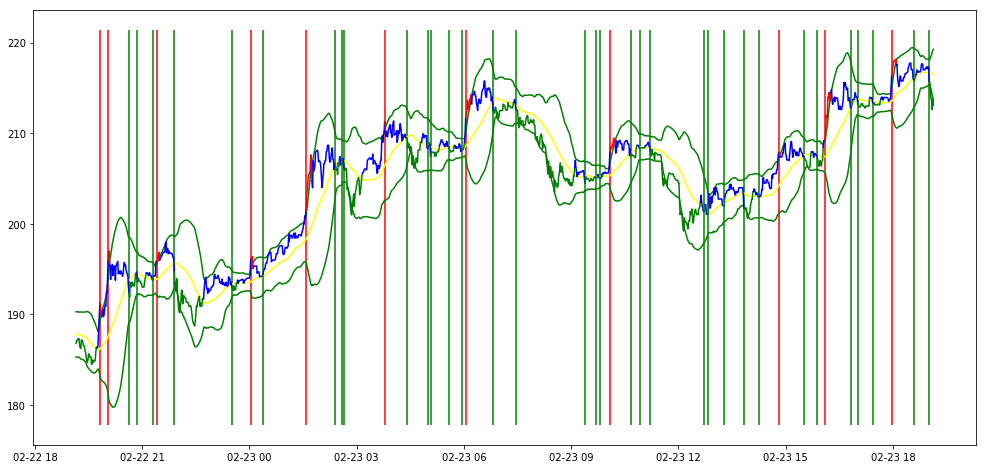

Trades 460 | Cash $ 60.99 | Cost $ 105.64
Value Distribution


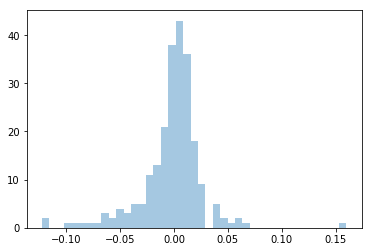

Average Change: -0.1734 %
Max Drawdown: -12.2150 %


In [227]:


max_loss = False
target_percent = False

final = data.copy()
final = final.sort_index( ascending = True)
day = 15
final = final.loc[datetime.today()- timedelta(days = (1 + day)):datetime.today()- timedelta(days = day)]

fig, ax = plt.subplots()
fig.set_size_inches(13 * 1.3, 8 )
test = Testy(stoploss= max_loss, target_percent= target_percent)
test.test_signal(final['close'], final['signal'])
print(test)


test = Testy(stoploss= max_loss, target_percent= target_percent)
test.test_signal(data['close'], data['signal'])
print(test)


ax.plot(final.index, final['upper'], color=  'green')
ax.plot(final.index, final['lower'], color=  'green')
ax.plot(final.index, final['avg'], color=  'yellow')
plot_signal(ax, final['close'], final['signal'])



#ax_v = ax.twinx()
#ax_v.bar(x = final.index,height=  final['vol_up'], width = 0.0025, alpha = .1, color = 'green')
#ax_v.bar(x = final.index,height=  final['vol_down'], width = 0.0025, alpha = .1, color = 'red')
    

plt.show()
test.study()